# Taste of Fine Wine <a class="tocSkip">

# Goal <a class="tocSkip">

- Determine drivers of quality
- Utilize drivers to create a model to predict quality
- Develop deeper understanding on how drivers influence quality

# Executive Summmary <a class="tocSkip">

- Answer Questions: 
    1. Does the proportion of acid to (alcohol + sugar) affect quality?
    2. Are white and red wines’ quality is different?
    3. Does the proportion of acid to chlorides affect quality?
    4. Does density affects the quality of wine?
- Takeways: 
    - Alcohol, volatile acidity, density, and chlorides influence quality
    - Model improves upon the baseline by 0.13 RMSE.

# Imports <a class="tocSkip">

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# py modules
import acquire as a
import explore as e
import visual as viz
import model as m

from math import sqrt

# hypothesis testing
from scipy import stats
from scipy.stats import pearsonr, spearmanr, ttest_1samp, ttest_ind, chi2_contingency

# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
import sklearn.preprocessing
from sklearn.feature_selection import RFE
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

seed = 21

# Acquired <a class="tocSkip">

- To acquire data, go to data.world and download red wine and white wine data.
    - link: https://data.world/food/wine-quality

In [2]:
# Acquire Data
df = a.get_wine()

# Add Exploration columns
df = e.add_exploration_columns(df)

# Prepare <a class="tocSkip">

- Normalized column names
- No null values discovered
- Outliers left untouched
- Feature engineered columns using existing data
    - Total acidity divided by alcohol plus sugar
    - Total acidity divided by chlorides

In [3]:
# Split Data
train, X_train, y_train, X_val, y_val, X_test, y_test = e.split_data(df,'quality')

# Scale Data
X_train_s,X_val_s,X_test_s = e.scale_minmax(X_train,X_val,X_test)

# Deep copy of scaled dataset with quality column added
train_scaled = e.copy_train(X_train_s, train)

# Dropping infinite values
X_train_s, X_val_s, X_test_s, y_train, y_val, y_test =\
m.drop_infinite(X_train_s, X_val_s, X_test_s, y_train, y_val, y_test)

# Data Dictionary  <a class="tocSkip">

In [4]:
%%html
<style>
table {float:left}
</style>

| Feature | Definition |
| :-- | :-- |
| fixed_acidity | predominant fixed acids found in wines are tartaric, malic, citric, and succinic |
| volatile_acidity | the steam distillable acids present in wine, primarily acetic acid but also lactic, formic, butyric, and propionic acids |
| citric_acid | citric acid |
| residual_sugar | natural sugars left over after fermentation | 
| chlorides | compound that plays a major role in a wine's salt profile |
| free_sulfur_dioxide | sulphur dioxide ions that are not chemically bound to other chemicals |
| total_sulfur_dioxide | free sulfur dioxide plus those that are not bound to other chemicals |
| pH | scale used to measure acidity |
| sulphates | salts of sulfuric acid |
| alcohol | alcohol |
| quality | rating of wine |
| color_red | 0 = white wine<br>1 = red wine<br>|
| acid_alc_sugar | Total acidity divided by alcohol plus sugar |
| acid_chlor |Total acidity divided by chlorides |

# Explore <a class="tocSkip">

Questions: 
1. Does the proportion of acid to (alcohol + sugar) affect quality?
2. Are white and red wines’ quality is different?
3. Does the proportion of acid to chlorides affect quality?
4. Does density affects the quality of wine?

In [5]:
# Creating Cluster column
X_train_s, X_val_s, X_test_s = e.cluster_Xsets(X_train_s, X_val_s, X_test_s, ['alcohol','volatile_acidity','density','chlorides'])

##  Cluster Plots for Alcohol, Volatile Acidity, and Density <a class="tocSkip">


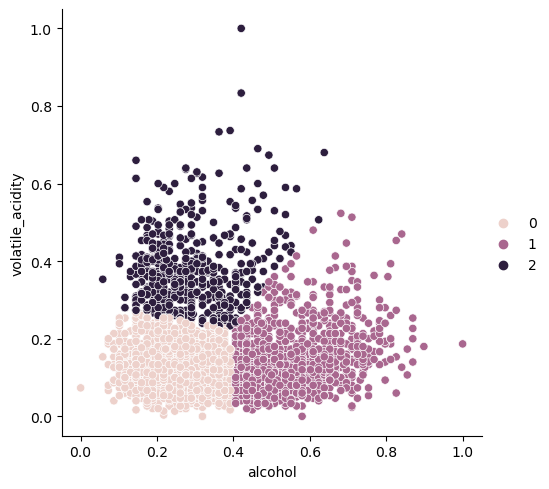

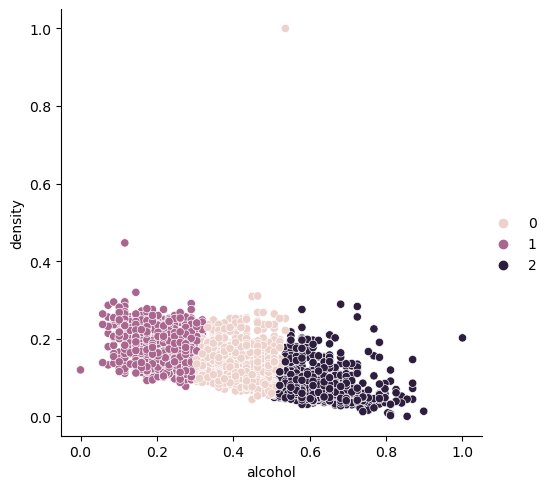

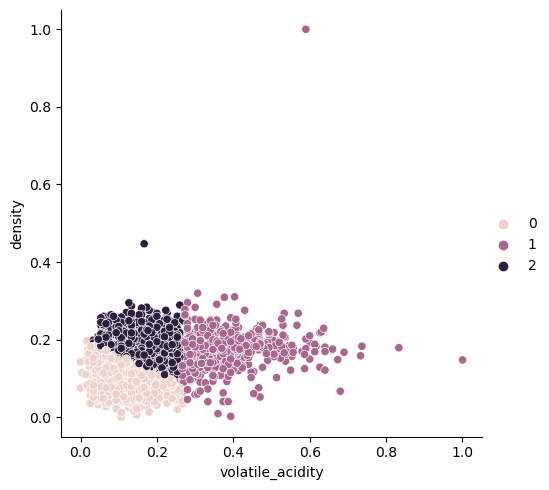

In [6]:
# Plot clusters
e.plot_clusters(X_train_s,'alcohol','volatile_acidity','density')

# Q1. Does the proportion of acid to (alcohol + sugar) affect quality? <a class="tocSkip">

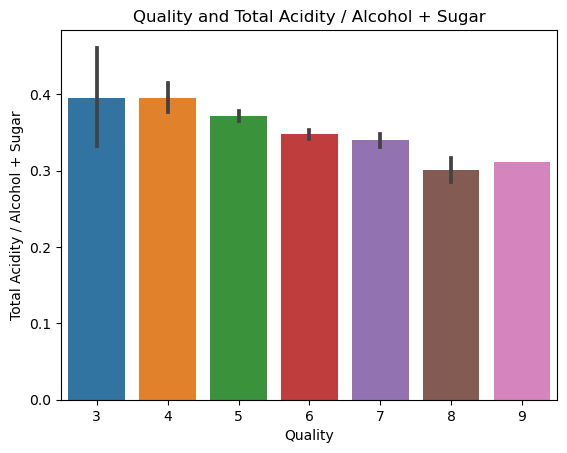

In [7]:
# Barplot of total acidity divided by alcohol+sugar
viz.barplot1(train)

### Takeaways: The higher the proportion of total acidity to alcohol and suger, the lower the quality <a class="tocSkip">

## Stats Test <a class="tocSkip">

In [8]:
# Spearman's Test
viz.spearman1(train_scaled)

Spearman's R Test Results
--------------------------
Correlation: -0.14
P-value: 2.3582308636003602e-17


# Q2. Are white and red wines’ quality different? <a class="tocSkip">

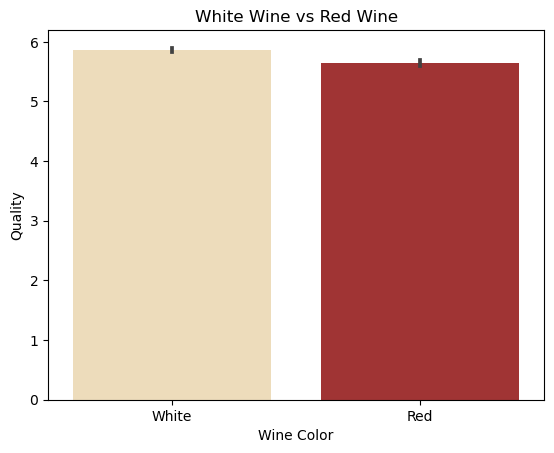

In [9]:
# Barplot of white wine vs red wine
viz.barplot2(train)

### Takeaways: White wine, on average, is of slightly higher quality than red wine. <a class="tocSkip">

## Stats Test <a class="tocSkip">

In [10]:
# Chi Square test
viz.chi(train_scaled)

Chi-square Test Results
-----------------------
Chi value: 67.49
p-value: 1.3387911526612644e-12


# Q3. Does the proportion of acid to chlorides affect quality? <a class="tocSkip">

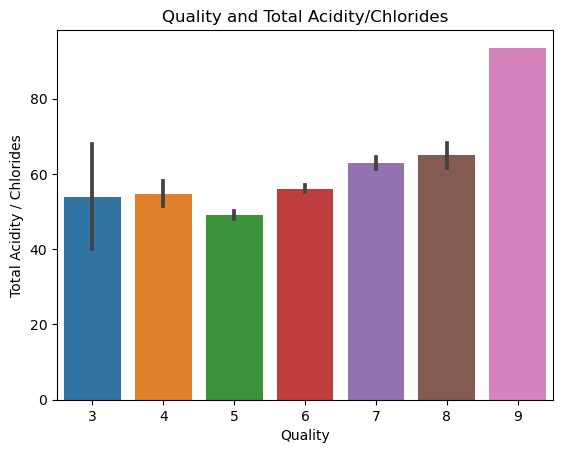

In [11]:
# Barplot of total acidity divided by chlorides
viz.barplot3(train)

### Takeaways: the higher the proportion of total acidity and chlorides, the higher the quality. <a class="tocSkip">

## Stats Test <a class="tocSkip">

In [12]:
# Spearman's R test
viz.spearman2(train_scaled)

Spearman's R Test Results
--------------------------
Correlation: 0.26
P-value: 1.0376033510870366e-58


# Q4. Does density affect the quality of wine? <a class="tocSkip">

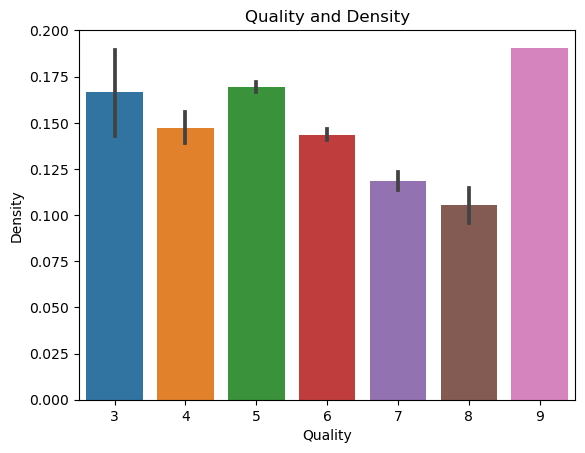

In [13]:
# Barplot
viz.barplot4(train_scaled)

### Takeaways: Except for a quality of 9, the higher the density, the lower the quality. <a class="tocSkip">

## Stats Test <a class="tocSkip">

In [14]:
# Pearson R test
viz.pearsonr(train_scaled)

Pearson's R Test Results
-------------------------
Correlation: -0.14
P-value: 1.2129165060754792e-17


## Explore Summary <a class="tocSkip">

<div class="alert alert-success">
- All four variables and their proportions have shown to have some impact on quality. 
</div>

# Modeling <a class="tocSkip">

In [15]:
initial_models = m.run_models(X_train_s, X_val_s, X_test_s, y_train, y_val, 'quality').sort_values('rmse_val')
initial_models.sort_values('difference', ascending=False)

,model,rmse_train,rmse_val,difference
1,lm,0.730133,0.737216,-0.007083
12,tweedie1_pf3,0.764065,0.774845,-0.010780
8,tweedie1_pf2,0.783637,0.796736,-0.013099
7,tweedie0_pf2,0.834354,0.848823,-0.014469
4,tweedie1,0.834264,0.848985,-0.014722
11,tweedie0_pf3,0.806771,0.822208,-0.015436
3,tweedie0,0.865373,0.880985,-0.015612
0,baseline,0.867745,0.883757,-0.016012
2,lass,0.867745,0.883757,-0.016012
6,lass_pf2,0.867745,0.883757,-0.016012


##  Comparing Models<a class="tocSkip">

<div class="alert alert-success">
- Lowest value was 0.70 but a differnce of -0.03.<br>
- Basic linear regression has an rmse of 0.73 and a differenc of 0. <br>
- Linear Regression will move on to the test data set.
</div>

# Regression Model on Test Set <a class="tocSkip">

In [24]:
lm = LinearRegression()
lm.fit(X_train_s,y_train['quality'])
preds = lm.predict(X_test_s)
test_rmse = e.calc_rmse(y_test['quality'],preds)

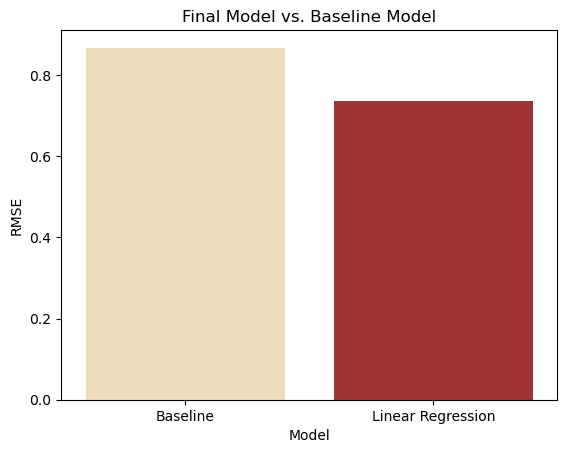

In [27]:
baseline_rmse = initial_models[initial_models.model=='baseline']['rmse_train'][0]
final = pd.DataFrame({'Model':['Baseline','Linear Regression'],'RMSE':[baseline_rmse,test_rmse]})
sns.barplot(data=final,x='Model',y='RMSE',palette=['wheat','firebrick'])
plt.title('Final Model vs. Baseline Model')
plt.show()

-  Baseline = 0.87
- Linear Regression = 0.74

# Conclusion <a class="tocSkip">

<div class="alert alert-success">
- Determined that alcohol, volatile acidity, density, and chlorides have significant influence on a wine's quality.<br>
- Our model improves upon the baseline by 0.13 on the RMSE value. 
</div>

# Next Steps <a class="tocSkip">

- Use different features such as sulfur dioxide and pH to see how they influence quality.
- Gather data on tannins to see how they influence quality.